**Step 0 - install and import dependencies**

In [1]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

     |████████████████████████████████| 11.0 MB 15.0 MB/s 
     |████████████████████████████████| 743 kB 41.2 MB/s 
     |████████████████████████████████| 4.9 MB 16.2 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 1.1 MB 36.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=68564531cd96a07f47eab53b24cb17d129693a999736a1b627e6eadbc22bab8d
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=611c04eede3aecd53e04c17c5b14a7c991fcab9bd5e419bfaefc4d2394cc0ad3
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [2]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [3]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [4]:
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [5]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [6]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [7]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

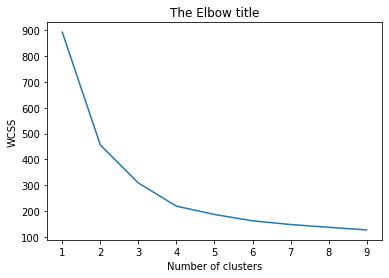

In [291]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [292]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [293]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [294]:
df_kmeans

,KMeans ID,texts
0,0,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
1,1,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
2,2,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
3,3,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...


In [295]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [296]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [297]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [298]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [299]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [300]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [333]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ["u", "b", "n", "nn", "nn-", "\n", "ร้าน", "กก", "ดิชั้น", "ดังนั้น", "ตั้งอยู่", "ลอง", 
                 "['", "ดิ", "tamp", "น", "ซอย", "ร้า", "ลอง", "ชั้น", "เจอ", "คน", "นั่ง",
                 "นึง", "อ", "ไหม", "วัง", "พันธุ์", "เวลา", "โมง", "สันทัด", "ดังนั้น", "เฉพาะเรื่อง",
                 "nTamp", "สั่ง", "(", ")", "]", "-", "ช้ัน" , "ทบ", "โถม", "เลือก", "review","แก้",
                 "ร่างกาย", "รอบ", "ย้ำ", "มีผลต่อ", "ช๊อต", "บาท", "พี่", "เรื่อง"]
screening_words = stopwords + removed_words

new_words = {"สตารบัก", "แบล๊กแคนยอน", "ช๊อคโกแล๊ต", "ช้อคโกแลต", "คาเฟ่", "โฮมเมด", "สมูตตี้", "แม่ศรีเรือน", 
             "ยำแซ่บ", "อีสาน", "คาปู", "อิตาเลี่ยนโซดา", "บาริสต้า", "ดาร์คช๊อก", "ชานมไข่มุก", "เมล็ดกาแฟ"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [334]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [335]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[ชอบ, ทาน, Macchiato, เป็นประจำ, เด, ArtofCoff...","[(ร้านกาแฟ, 22), (กาแฟ, 19), (ทาน, 11), (ชอบ, ..."
1,1,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(กิน, 10), (อร่อย, 9), (ทาน, 7), (ผม, 7), (รี..."
2,2,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 11), (กิน, 7), (อร่อย, 6), (อาหาร..."
3,3,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า, บ่าย, เย็...","[(ชา, 9), (ชานมไข่มุก, 9), (ทาน, 6), (ไข่มุก, ..."


In [336]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ร้านกาแฟ', 22), ('กาแฟ', 19), ('ทาน', 11), ('ชอบ', 8), ('คาเฟ่', 6), ('กิน', 6), ('แวะ', 6), ('น่ารัก', 5), ('เบเกอรี่', 4), ('พาย', 4)]

Cluster ID : 1

Most common words include : [('กิน', 10), ('อร่อย', 9), ('ทาน', 7), ('ผม', 7), ('รีวิว', 7), ('บ้าน', 5), ('ร้านกาแฟ', 5), ('กาแฟ', 5), ('อาหาร', 4), ('ชอบ', 4)]

Cluster ID : 2

Most common words include : [('ร้านอาหาร', 11), ('กิน', 7), ('อร่อย', 6), ('อาหาร', 6), ('ทาน', 5), ('ราคา', 5), ('สวัสดี', 4), ('เพื่อน', 4), ('ส้มตำ', 4), ('ไทย', 4)]

Cluster ID : 3

Most common words include : [('ชา', 9), ('ชานมไข่มุก', 9), ('ทาน', 6), ('ไข่มุก', 5), ('นม', 5), ('เครื่องดื่ม', 4), ('รีวิว', 3), ('เดิน', 3), ('ไต้หวัน', 3), ('แวะ', 2)]



**Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [337]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters=10, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [338]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [339]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [340]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('อร่อย', 508), ('ทาน', 416), ('รสชาติ', 407), ('ดี', 347), ('กิน', 339), ('เมนู', 309), ('กาแฟ', 307), ('อาหาร', 285), ('ราคา', 273), ('ชอบ', 229)]

Cluster ID : 1

Most common words include : [('แตงโม', 22), ('น้ำ', 8), ('ปั่น', 6), ('เนื้อ', 6), ('ซื้อ', 4), ('ดื่ม', 4), ('รับประทาน', 3), ('อาหาร', 3), ('เมล็ด', 2), ('มีรส', 2)]

Cluster ID : 2

Most common words include : [('แย่มาก', 3), ('โต๊ะ', 2), ('รอง', 2), ('แก้ว', 2), ('อาหาร', 1), ('เย็น', 1), ('แม่ศรีเรือน', 1), ('โฮมโปร', 1), ('แขก', 1), ('พนักงานบริการ', 1)]

Cluster ID : 3

Most common words include : [('นม', 3), ('แน่น', 2), ('เท', 2), ('ขนม', 1), ('กาแฟร้อน', 1), ('มากเกินไป', 1), ('กาแฟ', 1), ('ซ๊อต', 1), ('เล่น', 1), ('รอง', 1)]



**Step 4 - result discussion**

Cluster 1: Enjoy Eating

ลูกค้ากลุ่มนี้มักรีวิวว่าได้ทานอาหารที่มีรสชาติอร่อย กาแฟรสชาติดี ราคาก็ดี โดยรวมชื่นชอบ มีความประทับใจ ดังนั้นควรรักษามาตรฐานเดิมของร้านในทุกๆด้าน

Cluster 2: Enjoy Watermelon

ลูกค้ากลุ่มนี้มักรีวิวว่าได้ดื่มน้ำแตงโมปั่นที่มีรสชาติดี แต่เมล็ดเยอะไปหน่อย ดังนั้นควรเอาเมล็ดออกให้หมดก่อนนำไปปั่น ลูกค้าจะได้เกิดความพึงพอใจ

Cluster 3: Dislike Service

ลูกค้ากลุ่มนี้ได้ไปรับประทานอาหารที่ร้านแม่ศรีเรือน สาขาโฮมโปร ซึ่งพนักงานบริการแย่มาก ดังนั้นร้านควรปรับปรุงการให้บริการให้ดียิ่งขึ้น พนักงานควรมีใจรักบริการมากกว่านี้

Cluster 4: Dislike Texture

ลูกค้ากลุ่มนี้มักซื้อนมและกาแฟมาทาน แต่ร้านที่ซื้อรสชาติไม่โอเค ไม่เข้มข้น ไม่มากเกินไปก็น้อยเกินไป ดังนั้นร้านควรปรับปรุงรสชาติให้มีเอกลักษณ์และทำให้อร่อยกว่านี้